# What sells a car?

You're an analyst at Crankshaft List. Hundreds of free advertisements for vehicles are published on your site every day. You need to study data collected over the last few years and determine which factors influence the price of a vehicle.

## Initialization

In [5]:
# Loading all the libraries
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import seaborn as sns


### Load data

In [6]:
# Load the data file into a DataFrame
data = pd.read_csv('vehicles_us.csv')

### Explore initial data

The dataset contains the following fields:
- `price`
- `model_year`
- `model`
- `condition`
- `cylinders`
- `fuel` — gas, diesel, etc.
- `odometer` — the vehicle's mileage when the ad was published
- `transmission`
- `paint_color`
- `is_4wd` — whether the vehicle has 4-wheel drive (Boolean type)
- `date_posted` — the date the ad was published
- `days_listed` — from publication to removal



In [7]:
# print the general/summary information about the DataFrame
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51525 entries, 0 to 51524
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         51525 non-null  int64  
 1   model_year    47906 non-null  float64
 2   model         51525 non-null  object 
 3   condition     51525 non-null  object 
 4   cylinders     46265 non-null  float64
 5   fuel          51525 non-null  object 
 6   odometer      43633 non-null  float64
 7   transmission  51525 non-null  object 
 8   type          51525 non-null  object 
 9   paint_color   42258 non-null  object 
 10  is_4wd        25572 non-null  float64
 11  date_posted   51525 non-null  object 
 12  days_listed   51525 non-null  int64  
dtypes: float64(4), int64(2), object(7)
memory usage: 5.1+ MB


In [8]:
# print a sample of data
data.head(10)

,price,model_year,model,condition,cylinders,fuel,odometer,transmission,type,paint_color,is_4wd,date_posted,days_listed
0,9400,2011.0,bmw x5,good,6.0,gas,145000.0,automatic,SUV,NaN,1.0,2018-06-23,19
1,25500,NaN,ford f-150,good,6.0,gas,88705.0,automatic,pickup,white,1.0,2018-10-19,50
2,5500,2013.0,hyundai sonata,like new,4.0,gas,110000.0,automatic,sedan,red,NaN,2019-02-07,79
3,1500,2003.0,ford f-150,fair,8.0,gas,NaN,automatic,pickup,NaN,NaN,2019-03-22,9
4,14900,2017.0,chrysler 200,excellent,4.0,gas,80903.0,automatic,sedan,black,NaN,2019-04-02,28
5,14990,2014.0,chrysler 300,excellent,6.0,gas,57954.0,automatic,sedan,black,1.0,2018-06-20,15
6,12990,2015.0,toyota camry,excellent,4.0,gas,79212.0,automatic,sedan,white,NaN,2018-12-27,73
7,15990,2013.0,honda pilot,excellent,6.0,gas,109473.0,automatic,SUV,black,1.0,2019-01-07,68
8,11500,2012.0,kia sorento,excellent,4.0,gas,104174.0,automatic,SUV,NaN,1.0,2018-07-16,19
9,9200,2008.0,honda pilot,excellent,NaN,gas,147191.0,automatic,SUV,blue,1.0,2019-02-15,17


# Issues with the data frame
* The columns: 'model_year', 'cylinders', 'odometer', 'paint_color', and 'is_4wd' have missing data.


* The columns: 'model_year', 'cylinders', and 'is_42wd'  type can be changed from float to int


* The column: 'date_posted' type need to be changed into datetime


* The column: 'is_4wd' missing values should be replaced with zeros becase they simbolized non 4wd drive.

## Treat missing values (if any)

In [16]:
print(data.groupby('is_4wd')['model'].value_counts())

is_4wd  model          
0       toyota camry       976
        honda accord       948
        nissan altima      802
        honda civic        785
        ford focus         749
                          ... 
1       nissan versa         2
        hyundai elantra      1
        kia soul             1
        nissan maxima        1
        nissan sentra        1
Name: model, Length: 194, dtype: int64


In [10]:
data_mis = data.isnull().sum().to_frame('missing_values')
data_mis['%'] = round(data.isnull().sum()/len(data),3)
data_mis.sort_values(by='%', ascending=False)

,missing_values,%
is_4wd,25953,0.504
paint_color,9267,0.180
odometer,7892,0.153
cylinders,5260,0.102
model_year,3619,0.070
price,0,0.000
model,0,0.000
condition,0,0.000
fuel,0,0.000
transmission,0,0.000


In [11]:
# Replacing missing values in 'is_4wd' column with zero's. 0 = not 4wd drive.
data['is_4wd'] = data['is_4wd'].fillna(0)
data['is_4wd'] = data['is_4wd'].astype(int)

In [12]:
print("missing values in 'is_4wd' column:")
data['is_4wd'].isnull().sum()

missing values in 'is_4wd' column:


0

##### 'model_year' column has small amount of missing values so I can ignore it or delete them. to be decided.

#### The odometer column have high percentage of missing values, I want to group the data by year and catagorize it so i can find the proper mean or median to replace the missing values.

In [19]:
#model_year missing values, grouping by model and filling by median.
relevant_years = data.query('model_year>1992')
group_years = relevant_years.groupby('model')['model_year'].median()
# filling by median year based on model.
for i in group_years.index:
    data.loc[(data['model'] == i) & (data['model_year'].isnull()), 'model_year'] =\
    group_years[i]
data['model_year'] = data['model_year'].astype(int)

In [20]:
# replacing cylinders misiing values by mean grouped by model and model _year
data['cylinders'].value_counts()
data['cylinders'] = data.groupby(['model', 'model_year'])['cylinders'].transform(lambda grp: grp.fillna(np.mean(grp)))

data_mis = data.isnull().sum().to_frame('missing_values')
data_mis['%'] = round(data.isnull().sum()/len(data),3)
data_mis.sort_values(by='%', ascending=False)

,missing_values,%
paint_color,9267,0.180
odometer,7892,0.153
cylinders,26,0.001
price,0,0.000
model_year,0,0.000
model,0,0.000
condition,0,0.000
fuel,0,0.000
transmission,0,0.000
type,0,0.000


In [21]:
# replacing odometer misiing vales by mean grouped by model _year
data['odometer'] = data.groupby([ 'model_year'])['odometer'].transform(lambda grp: grp.fillna(np.mean(grp)))

data_mis = data.isnull().sum().to_frame('missing_values')
data_mis['%'] = round(data.isnull().sum()/len(data),3)
data_mis.sort_values(by='%', ascending=False)

,missing_values,%
paint_color,9267,0.180
cylinders,26,0.001
price,0,0.000
model_year,0,0.000
model,0,0.000
condition,0,0.000
fuel,0,0.000
odometer,1,0.000
transmission,0,0.000
type,0,0.000


In [22]:
#Rounding odometer data
data['odometer'] = data['odometer'].round()

## Enrich data

In [23]:
# Add datetime values for when the ad was placed
data['date_posted'] = pd.to_datetime(data['date_posted'], format= '%Y-%m-%d')
# Adding month posted column
data['month_posted'] = pd.to_datetime(data['date_posted']).dt.month
# Adding day of the wek posted column
data['day_of_week_posted'] = pd.to_datetime(data['date_posted']).dt.weekday
data.head()

,price,model_year,model,condition,cylinders,fuel,odometer,transmission,type,paint_color,is_4wd,date_posted,days_listed,month_posted,day_of_week_posted
0,9400,2011,bmw x5,good,6.0,gas,145000.0,automatic,SUV,NaN,1,2018-06-23,19,6,5
1,25500,2011,ford f-150,good,6.0,gas,88705.0,automatic,pickup,white,1,2018-10-19,50,10,4
2,5500,2013,hyundai sonata,like new,4.0,gas,110000.0,automatic,sedan,red,0,2019-02-07,79,2,3
3,1500,2003,ford f-150,fair,8.0,gas,162072.0,automatic,pickup,NaN,0,2019-03-22,9,3,4
4,14900,2017,chrysler 200,excellent,4.0,gas,80903.0,automatic,sedan,black,0,2019-04-02,28,4,1


In [24]:
# Add the vehicle's age when the ad was placed
data['vehicles_age'] =data['date_posted'].dt.year - data['model_year']

In [25]:
data.head()

,price,model_year,model,condition,cylinders,fuel,odometer,transmission,type,paint_color,is_4wd,date_posted,days_listed,month_posted,day_of_week_posted,vehicles_age
0,9400,2011,bmw x5,good,6.0,gas,145000.0,automatic,SUV,NaN,1,2018-06-23,19,6,5,7
1,25500,2011,ford f-150,good,6.0,gas,88705.0,automatic,pickup,white,1,2018-10-19,50,10,4,7
2,5500,2013,hyundai sonata,like new,4.0,gas,110000.0,automatic,sedan,red,0,2019-02-07,79,2,3,6
3,1500,2003,ford f-150,fair,8.0,gas,162072.0,automatic,pickup,NaN,0,2019-03-22,9,3,4,16
4,14900,2017,chrysler 200,excellent,4.0,gas,80903.0,automatic,sedan,black,0,2019-04-02,28,4,1,2


In [26]:
# Add the vehicle's average mileage per year

def mileage_per_age(row):
    age = row['vehicles_age']
    odometer=row['odometer']
    if age > 0:
        miles_per_year=(odometer/age)
    else:
        miles_per_year=odometer
    return miles_per_year

data['miles_per_year']=data.apply(mileage_per_age,axis=1) 

In [27]:
data.head()

,price,model_year,model,condition,cylinders,fuel,odometer,transmission,type,paint_color,is_4wd,date_posted,days_listed,month_posted,day_of_week_posted,vehicles_age,miles_per_year
0,9400,2011,bmw x5,good,6.0,gas,145000.0,automatic,SUV,NaN,1,2018-06-23,19,6,5,7,20714.285714
1,25500,2011,ford f-150,good,6.0,gas,88705.0,automatic,pickup,white,1,2018-10-19,50,10,4,7,12672.142857
2,5500,2013,hyundai sonata,like new,4.0,gas,110000.0,automatic,sedan,red,0,2019-02-07,79,2,3,6,18333.333333
3,1500,2003,ford f-150,fair,8.0,gas,162072.0,automatic,pickup,NaN,0,2019-03-22,9,3,4,16,10129.500000
4,14900,2017,chrysler 200,excellent,4.0,gas,80903.0,automatic,sedan,black,0,2019-04-02,28,4,1,2,40451.500000


In [28]:
# It might help to replace the condition values with something that can be manipulated more easily
data['condition'].value_counts()

excellent    24773
good         20145
like new      4742
fair          1607
new            143
salvage        115
Name: condition, dtype: int64

In [29]:
condition_dict = {
    'salvage':1,
    'fair':2,
    'good':3,
    'excellent':4,
    'like new':5,
    'new':6    
}

In [30]:
data['condition_cat'] = data['condition'].map(condition_dict)
data.head()

,price,model_year,model,condition,cylinders,fuel,odometer,transmission,type,paint_color,is_4wd,date_posted,days_listed,month_posted,day_of_week_posted,vehicles_age,miles_per_year,condition_cat
0,9400,2011,bmw x5,good,6.0,gas,145000.0,automatic,SUV,NaN,1,2018-06-23,19,6,5,7,20714.285714,3
1,25500,2011,ford f-150,good,6.0,gas,88705.0,automatic,pickup,white,1,2018-10-19,50,10,4,7,12672.142857,3
2,5500,2013,hyundai sonata,like new,4.0,gas,110000.0,automatic,sedan,red,0,2019-02-07,79,2,3,6,18333.333333,5
3,1500,2003,ford f-150,fair,8.0,gas,162072.0,automatic,pickup,NaN,0,2019-03-22,9,3,4,16,10129.500000,2
4,14900,2017,chrysler 200,excellent,4.0,gas,80903.0,automatic,sedan,black,0,2019-04-02,28,4,1,2,40451.500000,4


## Check clean data

In [31]:
# print the general/summary information about the DataFrame
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51525 entries, 0 to 51524
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   price               51525 non-null  int64         
 1   model_year          51525 non-null  int32         
 2   model               51525 non-null  object        
 3   condition           51525 non-null  object        
 4   cylinders           51499 non-null  float64       
 5   fuel                51525 non-null  object        
 6   odometer            51524 non-null  float64       
 7   transmission        51525 non-null  object        
 8   type                51525 non-null  object        
 9   paint_color         42258 non-null  object        
 10  is_4wd              51525 non-null  int32         
 11  date_posted         51525 non-null  datetime64[ns]
 12  days_listed         51525 non-null  int64         
 13  month_posted        51525 non-null  int64     

In [32]:
data_mis = data.isnull().sum().to_frame('missing_values')
data_mis['%'] = round(data.isnull().sum()/len(data),3)
data_mis.sort_values(by='%', ascending=False)

,missing_values,%
paint_color,9267,0.180
cylinders,26,0.001
is_4wd,0,0.000
miles_per_year,1,0.000
vehicles_age,0,0.000
day_of_week_posted,0,0.000
month_posted,0,0.000
days_listed,0,0.000
date_posted,0,0.000
price,0,0.000


### replacing paint_color missing data with '-' and delete all other missing data because theire percentage is insignificant.

In [33]:
data['paint_color'].fillna('-', inplace=True)

In [34]:
# Saving the data with missing values as miss_data
miss_data = data

In [35]:
# Dropping all left misiing values
data = data.dropna()

In [36]:
data_mis = data.isnull().sum().to_frame('missing_values')
data_mis['%'] = round(data.isnull().sum()/len(data),3)
data_mis.sort_values(by='%', ascending=False)

,missing_values,%
price,0,0.0
model_year,0,0.0
miles_per_year,0,0.0
vehicles_age,0,0.0
day_of_week_posted,0,0.0
month_posted,0,0.0
days_listed,0,0.0
date_posted,0,0.0
is_4wd,0,0.0
paint_color,0,0.0


In [37]:
# print a sample of data
data.head()

,price,model_year,model,condition,cylinders,fuel,odometer,transmission,type,paint_color,is_4wd,date_posted,days_listed,month_posted,day_of_week_posted,vehicles_age,miles_per_year,condition_cat
0,9400,2011,bmw x5,good,6.0,gas,145000.0,automatic,SUV,-,1,2018-06-23,19,6,5,7,20714.285714,3
1,25500,2011,ford f-150,good,6.0,gas,88705.0,automatic,pickup,white,1,2018-10-19,50,10,4,7,12672.142857,3
2,5500,2013,hyundai sonata,like new,4.0,gas,110000.0,automatic,sedan,red,0,2019-02-07,79,2,3,6,18333.333333,5
3,1500,2003,ford f-150,fair,8.0,gas,162072.0,automatic,pickup,-,0,2019-03-22,9,3,4,16,10129.500000,2
4,14900,2017,chrysler 200,excellent,4.0,gas,80903.0,automatic,sedan,black,0,2019-04-02,28,4,1,2,40451.500000,4


## Study core parameters


The parameters are
- Price
- The vehicle's age when the ad was placed
- Mileage
- Number of cylinders
- Condition

###  function that analize outliers outside of 5 and 95 percentiles

In [38]:
def distribution_percentile(df, parameter):
    #printing histogram
    print('The histogram of: {}'.format(parameter))
    data[parameter].plot(kind='hist', bins=50, title=parameter + ' histogram', grid=True)
    plt.xlabel(parameter, size=12)
    plt.ylabel('frequancy', size=12)
    plt.show()
    
    #finding the side of skewrdnes by cheking mean and median
    if df[parameter].mean() > df[parameter].median():
        print('The distribution is skewed to the right')
    else:
        print('The distribution is skewed to the left')
    print('---------------------------------------')
    print('Statistics on {}'.format(parameter))
    print(df[parameter].describe())
    
    # Determin percentiles
    ninty_five = np.percentile(df[parameter], 95)
    five = np.percentile(df[parameter], 5)
    print('---------------------------------------')
    print('min border:',five)
    print('max border:',ninty_five)
    print('---------------------------------------')
    
    #printing borders and counting outliers
    print('The outliers are concidered to be the values below',five, "and above",ninty_five)
    print('We have',len(df[(df[parameter]<five)| (df[parameter]>ninty_five)]),"values that we can consider outliers")
    #Empty line
    print('')
        

The histogram of: price


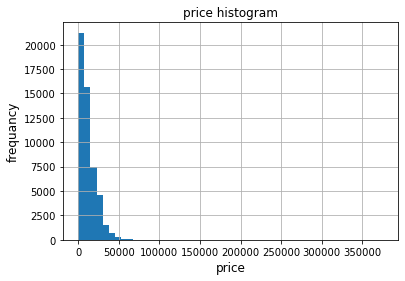

The distribution is skewed to the right
---------------------------------------
Statistics on price
count     51498.000000
mean      12132.501573
std       10034.808438
min           1.000000
25%        5000.000000
50%        9000.000000
75%       16849.000000
max      375000.000000
Name: price, dtype: float64
---------------------------------------
min border: 1950.0
max border: 30300.0
---------------------------------------
The outliers are concidered to be the values below 1950.0 and above 30300.0
We have 5133 values that we can consider outliers

The histogram of: vehicles_age


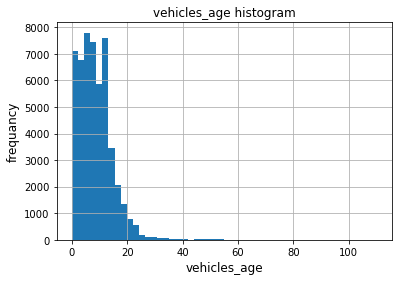

The distribution is skewed to the right
---------------------------------------
Statistics on vehicles_age
count    51498.000000
mean         8.496738
std          6.069194
min          0.000000
25%          4.000000
50%          7.000000
75%         12.000000
max        110.000000
Name: vehicles_age, dtype: float64
---------------------------------------
min border: 1.0
max border: 19.0
---------------------------------------
The outliers are concidered to be the values below 1.0 and above 19.0
We have 4202 values that we can consider outliers

The histogram of: miles_per_year


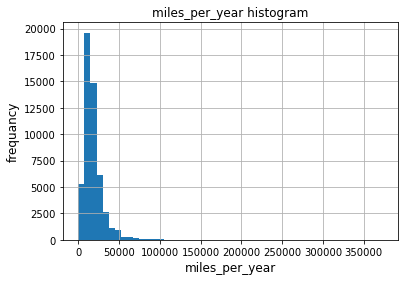

The distribution is skewed to the right
---------------------------------------
Statistics on miles_per_year
count     51498.000000
mean      17875.203757
std       12557.349599
min           0.000000
25%       10875.000000
50%       15260.500000
75%       21357.142857
max      373200.000000
Name: miles_per_year, dtype: float64
---------------------------------------
min border: 4716.0
max border: 39835.666666666664
---------------------------------------
The outliers are concidered to be the values below 4716.0 and above 39835.666666666664
We have 5147 values that we can consider outliers

The histogram of: odometer


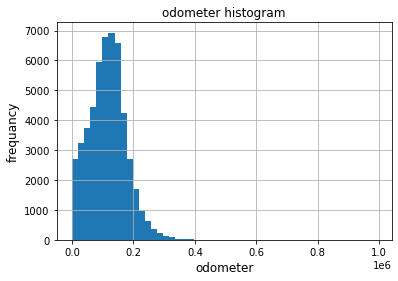

The distribution is skewed to the right
---------------------------------------
Statistics on odometer
count     51498.000000
mean     115535.048973
std       61857.210755
min           0.000000
25%       73500.000000
50%      114078.000000
75%      151969.000000
max      990000.000000
Name: odometer, dtype: float64
---------------------------------------
min border: 18500.0
max border: 216500.0
---------------------------------------
The outliers are concidered to be the values below 18500.0 and above 216500.0
We have 5143 values that we can consider outliers

The histogram of: cylinders


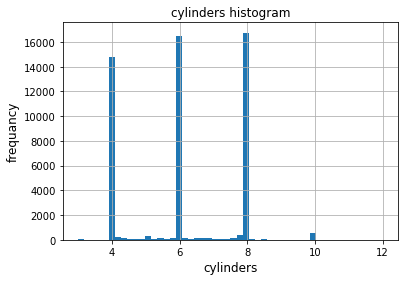

The distribution is skewed to the right
---------------------------------------
Statistics on cylinders
count    51498.000000
mean         6.123829
std          1.648149
min          3.000000
25%          4.000000
50%          6.000000
75%          8.000000
max         12.000000
Name: cylinders, dtype: float64
---------------------------------------
min border: 4.0
max border: 8.0
---------------------------------------
The outliers are concidered to be the values below 4.0 and above 8.0
We have 778 values that we can consider outliers

The histogram of: condition_cat


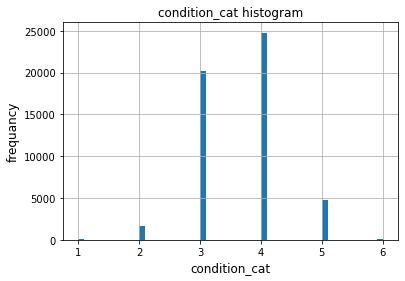

The distribution is skewed to the left
---------------------------------------
Statistics on condition_cat
count    51498.000000
mean         3.637559
std          0.712272
min          1.000000
25%          3.000000
50%          4.000000
75%          4.000000
max          6.000000
Name: condition_cat, dtype: float64
---------------------------------------
min border: 3.0
max border: 5.0
---------------------------------------
The outliers are concidered to be the values below 3.0 and above 5.0
We have 1860 values that we can consider outliers



In [39]:
# A loop to analize all relevant columns
for parameter in ['price', 'vehicles_age', 'miles_per_year','odometer', 'cylinders', 'condition_cat']:
    distribution_percentile(data, parameter)

## Study and treat outliers



In [40]:
#Creating border list
border_list = []
for parameter in ['price', 'vehicles_age', 'miles_per_year', 'cylinders', 'condition_cat', 'odometer']:
    ninety_five = np.percentile(data[parameter], 95)
    five = np.percentile(data[parameter], 5)
    border_list.append([parameter,five,ninety_five])


In [41]:
#creating a table of border data
border_data = pd.DataFrame(border_list, columns=['Paramteter', 'Min_border', 'Max_border'])
border_data

,Paramteter,Min_border,Max_border
0,price,1950.0,30300.000000
1,vehicles_age,1.0,19.000000
2,miles_per_year,4716.0,39835.666667
3,cylinders,4.0,8.000000
4,condition_cat,3.0,5.000000
5,odometer,18500.0,216500.000000


In [42]:
data_clean = data.copy()

In [43]:
# Store data without outliers in a separate DataFrame
for parameter in ['price', 'vehicles_age', 'miles_per_year', 'cylinders', 'odometer']:
    ninty_five = np.percentile(data_clean[parameter], 95)
    five = np.percentile(data_clean[parameter], 5)
    data_clean = data_clean[(data_clean[parameter] >= five) & (data[parameter] <= ninty_five)]


C:\Users\boazo\AppData\Local\Temp/ipykernel_43272/3967493841.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_clean = data_clean[(data_clean[parameter] >= five) & (data[parameter] <= ninty_five)]


In [44]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51498 entries, 0 to 51524
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   price               51498 non-null  int64         
 1   model_year          51498 non-null  int32         
 2   model               51498 non-null  object        
 3   condition           51498 non-null  object        
 4   cylinders           51498 non-null  float64       
 5   fuel                51498 non-null  object        
 6   odometer            51498 non-null  float64       
 7   transmission        51498 non-null  object        
 8   type                51498 non-null  object        
 9   paint_color         51498 non-null  object        
 10  is_4wd              51498 non-null  int32         
 11  date_posted         51498 non-null  datetime64[ns]
 12  days_listed         51498 non-null  int64         
 13  month_posted        51498 non-null  int64     

In [45]:
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34661 entries, 0 to 51524
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   price               34661 non-null  int64         
 1   model_year          34661 non-null  int32         
 2   model               34661 non-null  object        
 3   condition           34661 non-null  object        
 4   cylinders           34661 non-null  float64       
 5   fuel                34661 non-null  object        
 6   odometer            34661 non-null  float64       
 7   transmission        34661 non-null  object        
 8   type                34661 non-null  object        
 9   paint_color         34661 non-null  object        
 10  is_4wd              34661 non-null  int32         
 11  date_posted         34661 non-null  datetime64[ns]
 12  days_listed         34661 non-null  int64         
 13  month_posted        34661 non-null  int64     

## Study core parameters without outliers

In [46]:
# Function to compare same column on two deferent data frames
def comparing_dataframes(df1, df2, parameter):
    #printing histogram
    print('The histograms of: {} before deleting outliers'.format(parameter))
    data[parameter].plot(kind='hist', bins=30, title=parameter + ' histogram', grid=True)
    plt.xlabel(parameter, size=12)
    plt.ylabel('frequancy', size=12)
    plt.show()
    
    print('The histograms of: {} clean data'.format(parameter))
    data_clean[parameter].plot(kind='hist', bins=20, title='clean '+parameter+' histogram', grid=True)
    plt.xlabel(parameter, size=12)
    plt.ylabel('frequancy', size=12)
    plt.show()
   

  
    print('Statistics on {} before cleaning'.format(parameter))
    print(df1[parameter].describe())
    print('')
    print('Statistics on {} clean data'.format(parameter))
    print(df2[parameter].describe())
    

The histograms of: price before deleting outliers


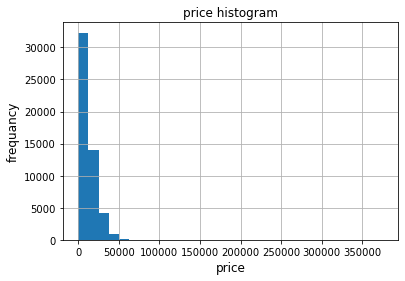

The histograms of: price clean data


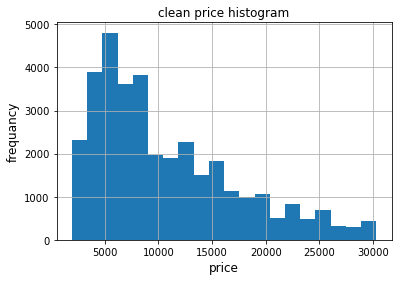

Statistics on price before cleaning
count     51498.000000
mean      12132.501573
std       10034.808438
min           1.000000
25%        5000.000000
50%        9000.000000
75%       16849.000000
max      375000.000000
Name: price, dtype: float64

Statistics on price clean data
count    34661.000000
mean     10651.899368
std       6589.900055
min       1950.000000
25%       5500.000000
50%       8900.000000
75%      14500.000000
max      30300.000000
Name: price, dtype: float64


In [47]:
# Compring price column 
comparing_dataframes(data, data_clean, 'price')

### price conclusion:
* After deleting the outliers we can see that most of the cars cost between 5500 and 14500 dollars
* The mean of the clean data is smaller which means that most of the outliers were expensive cars
* The data is obviosly still skewed to the right which means that some very expensive cars are still in the list.

The histograms of: vehicles_age before deleting outliers


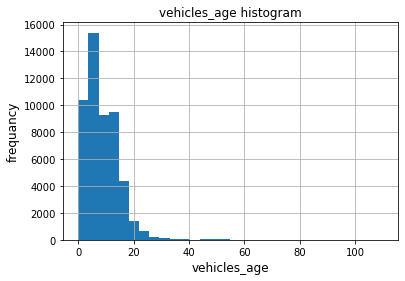

The histograms of: vehicles_age clean data


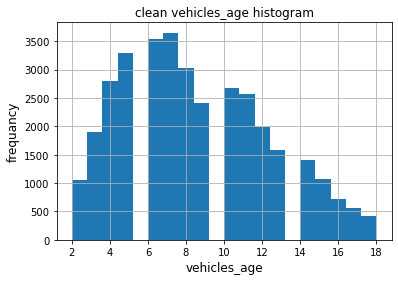

Statistics on vehicles_age before cleaning
count    51498.000000
mean         8.496738
std          6.069194
min          0.000000
25%          4.000000
50%          7.000000
75%         12.000000
max        110.000000
Name: vehicles_age, dtype: float64

Statistics on vehicles_age clean data
count    34661.000000
mean         8.417155
std          3.854896
min          2.000000
25%          5.000000
50%          8.000000
75%         11.000000
max         18.000000
Name: vehicles_age, dtype: float64


In [48]:
# Compring vehicles_age column
comparing_dataframes(data, data_clean, 'vehicles_age')

### Car age conclusion:
* We can see the most of the cars are around 6 years old, 9 years old and 11 years old
* The mean of the clean data is smaller due to some very old cars deleted as outliers, getting colser to the median!

The histograms of: miles_per_year before deleting outliers


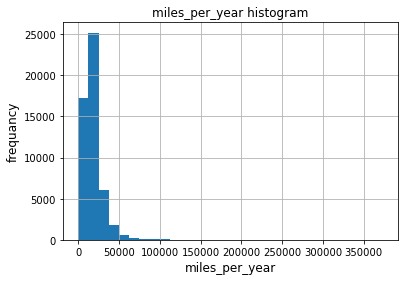

The histograms of: miles_per_year clean data


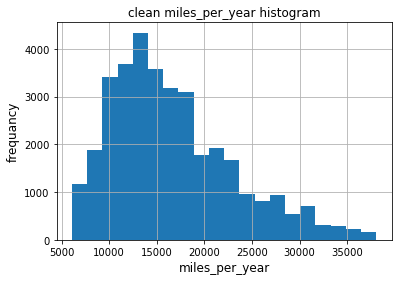

Statistics on miles_per_year before cleaning
count     51498.000000
mean      17875.203757
std       12557.349599
min           0.000000
25%       10875.000000
50%       15260.500000
75%       21357.142857
max      373200.000000
Name: miles_per_year, dtype: float64

Statistics on miles_per_year clean data
count    34661.000000
mean     16647.018691
std       6463.768048
min       6088.214286
25%      11800.000000
50%      15335.400000
75%      20415.000000
max      38055.500000
Name: miles_per_year, dtype: float64


In [49]:
# Compring odometer column
comparing_dataframes(data, data_clean, 'miles_per_year')

### Mileage per year conclusion:
* After deleting some unused cars we can see the distribution clearly
* The mileage data distributse normally and most of the cars have between 12000 and 20000 miles on them


The histograms of: odometer before deleting outliers


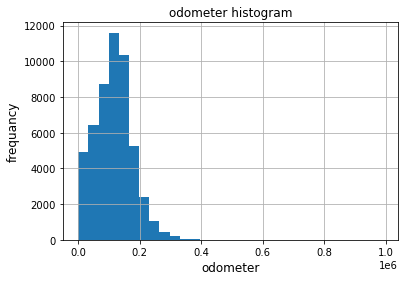

The histograms of: odometer clean data


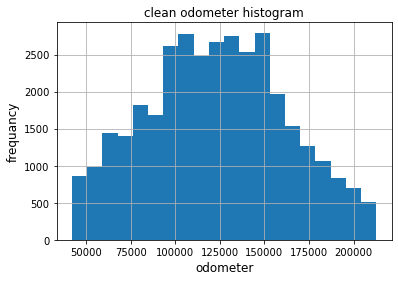

Statistics on odometer before cleaning
count     51498.000000
mean     115535.048973
std       61857.210755
min           0.000000
25%       73500.000000
50%      114078.000000
75%      151969.000000
max      990000.000000
Name: odometer, dtype: float64

Statistics on odometer clean data
count     34661.00000
mean     122656.73789
std       39240.64577
min       41964.00000
25%       93649.00000
50%      123859.00000
75%      151780.00000
max      212762.00000
Name: odometer, dtype: float64


In [50]:
# Compring odometer column
comparing_dataframes(data, data_clean, 'odometer')

### Mileage conclusion:
* After deleting some unused cars we can see the distribution clearly
* The mileage data distributse normally and most of the cars have between 10000 and 15000 miles on them
* the mean and the median are realy close!


The histograms of: cylinders before deleting outliers


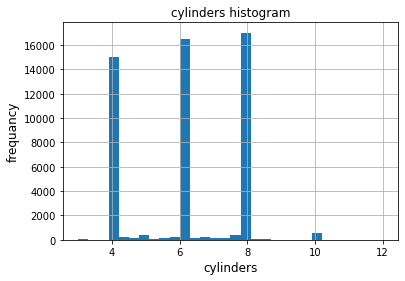

The histograms of: cylinders clean data


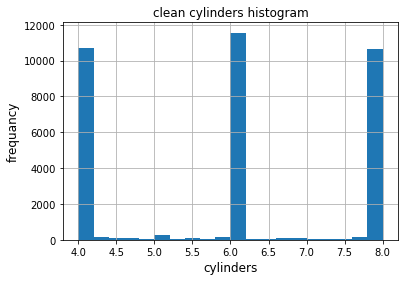

Statistics on cylinders before cleaning
count    51498.000000
mean         6.123829
std          1.648149
min          3.000000
25%          4.000000
50%          6.000000
75%          8.000000
max         12.000000
Name: cylinders, dtype: float64

Statistics on cylinders clean data
count    34661.000000
mean         5.989262
std          1.588743
min          4.000000
25%          4.000000
50%          6.000000
75%          8.000000
max          8.000000
Name: cylinders, dtype: float64


In [51]:
# Compring cylinders column
comparing_dataframes(data, data_clean, 'cylinders')

### Cylinders conclusion:
* We got rid of anomalis and left with 4, 6, and 8 cylinders

## Ads lifetime


In [52]:
data_clean['days_listed'].describe()

count    34661.000000
mean        39.576815
std         28.268847
min          0.000000
25%         19.000000
50%         33.000000
75%         53.000000
max        271.000000
Name: days_listed, dtype: float64

In [53]:
# Borders for days listed
ninety_five = np.percentile(data_clean['days_listed'], 95)
five = np.percentile(data_clean['days_listed'], 5)
print('Min border: {}'.format(five))
print('Max border: {}'.format(ninety_five))

Min border: 7.0
Max border: 94.0


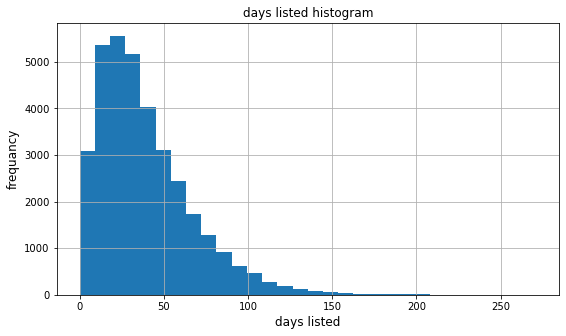

In [54]:
data_clean['days_listed'].plot(kind='hist', bins=30, title='days listed histogram', grid=True, figsize=(9,5))
plt.xlabel('days listed', size=12)
plt.ylabel('frequancy', size=12)
plt.show()

In [55]:
# I want to check short living and long living ads by model and model_year
days_by_model_year_model = data_clean.groupby(['model','model_year'])['days_listed'].agg(['count', 'median']).reset_index().sort_values(by='median')

In [56]:
#checking cars by model and model year that are sold less than 7 days sence the publication
short = days_by_model_year_model.query('median < 7')
short

,model,model_year,count,median
1465,volkswagen passat,2000,2,1.5
325,dodge charger,2017,1,2.0
1290,toyota 4runner,2017,1,4.0
903,honda pilot,2017,1,5.0
85,chevrolet corvette,2000,1,6.0


In [57]:
#checking cars by model and model year that are'nt in the first  97 days of the publication
long= days_by_model_year_model.query('median > 97')
long

,model,model_year,count,median
499,ford f-250 super duty,2016,1,110.0
226,chevrolet silverado 3500hd,2016,1,138.0
705,ford taurus,2000,1,148.0


### conclusion

* The median for days_listed is: 33
* The mean is: 39.58 (right skewed)
* most of the ads are published between 15 and 60 days
* the 5 percentile of the posts are posted less than 7 days
* the 95 percentile of the posts are posted more than 94 days
* therre are some models in specific years that are sold really fast or really slow

## Average price per each type of vehicle

In [58]:
#Grouping data
car_type = data_clean.groupby(['type'])['price'].agg(['count', 'mean']).reset_index().sort_values(by='count',ascending=False)
car_type

,type,count,mean
0,SUV,9004,10083.334962
9,sedan,8892,6676.055443
10,truck,7687,15003.084428
8,pickup,4251,14275.864973
12,wagon,1215,9080.746502
3,coupe,1043,10467.919463
5,mini-van,892,7550.224215
4,hatchback,765,6455.194771
11,van,429,8128.055944
2,convertible,194,12257.206186


Text(0.5, 1.0, 'Car type frequancy')

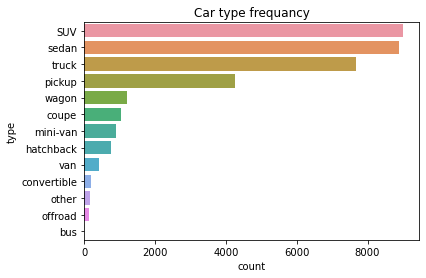

In [59]:
sns.barplot(data=car_type, x='count', y='type').set_title('Car type frequancy')

In [60]:
# select top 2 types with the most adds
top =list(car_type.head(2)['type'])
top

['SUV', 'sedan']

In [61]:
new_data = data_clean[data_clean.type.isin(top)]
new_data['type'].unique()

array(['SUV', 'sedan'], dtype=object)

### car type
* The offrod type is the most expensive one but one of the least published types
* The suv type is by far the most published type with 2875 adds, after it is the sedan with 1300 ads (less than half).

## Price factors

### SUV

In [62]:
SUV = new_data[new_data['type'] == 'SUV']
SUV

,price,model_year,model,condition,cylinders,fuel,odometer,transmission,type,paint_color,is_4wd,date_posted,days_listed,month_posted,day_of_week_posted,vehicles_age,miles_per_year,condition_cat
0,9400,2011,bmw x5,good,6.0,gas,145000.0,automatic,SUV,-,1,2018-06-23,19,6,5,7,20714.285714,3
7,15990,2013,honda pilot,excellent,6.0,gas,109473.0,automatic,SUV,black,1,2019-01-07,68,1,0,6,18245.500000,4
8,11500,2012,kia sorento,excellent,4.0,gas,104174.0,automatic,SUV,-,1,2018-07-16,19,7,0,6,17362.333333,4
9,9200,2008,honda pilot,excellent,6.0,gas,147191.0,automatic,SUV,blue,1,2019-02-15,17,2,4,11,13381.000000,4
14,12990,2009,gmc yukon,excellent,8.0,gas,132285.0,automatic,SUV,black,1,2019-01-31,24,1,3,10,13228.500000,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51495,9500,2012,chevrolet traverse,good,6.0,gas,144500.0,automatic,SUV,-,1,2019-03-05,1,3,1,7,20642.857143,3
51496,4999,2002,toyota 4runner,excellent,6.0,gas,177901.0,automatic,SUV,-,1,2018-05-26,59,5,5,16,11118.812500,4
51500,6995,2012,buick enclave,excellent,6.0,gas,157000.0,automatic,SUV,white,1,2018-08-04,17,8,5,6,26166.666667,4
51502,7995,2011,chevrolet equinox,like new,4.0,gas,111088.0,automatic,SUV,-,0,2019-04-01,175,4,0,8,13886.000000,5


In [63]:
for_scatter = SUV[['price','vehicles_age','miles_per_year', 'odometer', 'condition_cat','transmission','paint_color']]
for_scatter

,price,vehicles_age,miles_per_year,odometer,condition_cat,transmission,paint_color
0,9400,7,20714.285714,145000.0,3,automatic,-
7,15990,6,18245.500000,109473.0,4,automatic,black
8,11500,6,17362.333333,104174.0,4,automatic,-
9,9200,11,13381.000000,147191.0,4,automatic,blue
14,12990,10,13228.500000,132285.0,4,automatic,black
...,...,...,...,...,...,...,...
51495,9500,7,20642.857143,144500.0,3,automatic,-
51496,4999,16,11118.812500,177901.0,4,automatic,-
51500,6995,6,26166.666667,157000.0,4,automatic,white
51502,7995,8,13886.000000,111088.0,5,automatic,-


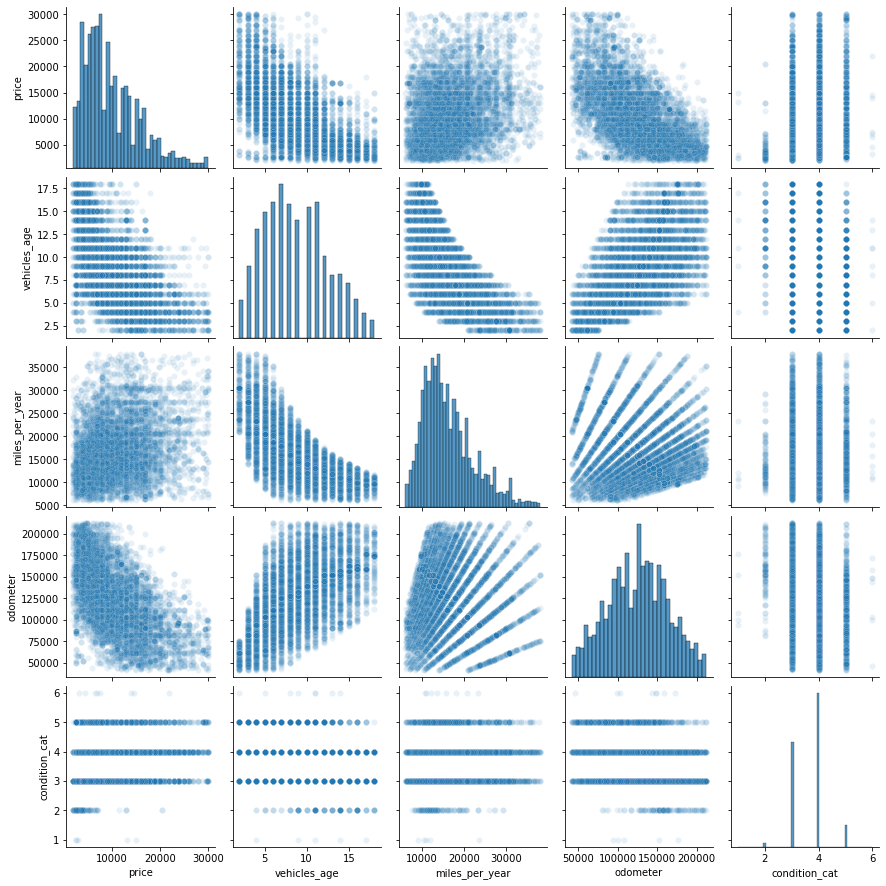

In [64]:
sns.pairplot(for_scatter, plot_kws={'alpha':0.1})

##### we already see negetive correlation between price and mileage

In [66]:
for_scatter.corr()

,price,vehicles_age,miles_per_year,odometer,condition_cat
price,1.000000,-0.607603,0.318219,-0.594021,0.203314
vehicles_age,-0.607603,1.000000,-0.715280,0.628097,-0.196535
miles_per_year,0.318219,-0.715280,1.000000,-0.036641,0.048864
odometer,-0.594021,0.628097,-0.036641,1.000000,-0.226809
condition_cat,0.203314,-0.196535,0.048864,-0.226809,1.000000


### Correlation
* vihecles age and price have strong negetive correlation
* vihecles age and mileage (odometer) have strong negetive correlation

In [67]:
##Making sure that it has more than 50 listings
SUV['transmission'].value_counts()

automatic    8575
manual        349
other          80
Name: transmission, dtype: int64

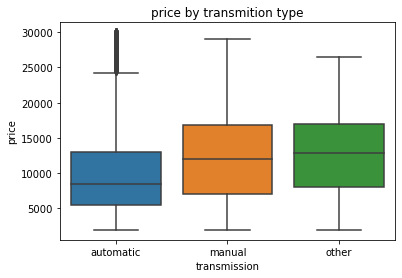

In [68]:
trans_bar=sns.boxplot(x="transmission", y="price", data=SUV).set_title('price by transmition type')

#### There is no big difference between transmissions. Therefore the transmission doesnt affect the price much.

In [69]:
##Making sure that it has more than 50 listings
SUV['paint_color'].value_counts()

-         1609
black     1578
white     1384
silver    1191
grey       879
blue       781
red        656
brown      300
green      275
custom     224
orange      69
purple      29
yellow      29
Name: paint_color, dtype: int64

In [70]:
#getting rid of categories with less than 50 counts
suv_paint = SUV.query("paint_color != ['yellow', 'purple', 'orange']")

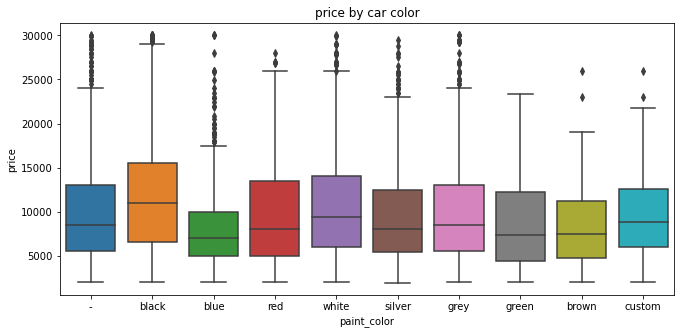

In [71]:
plt.figure(figsize=(11,5))
color_bar=sns.boxplot(x="paint_color", y="price", data=suv_paint).set_title('price by car color')
# if i had a lot of free time i would have matched the colors of the bars to the colors of the cars

#### Here too, there is no big difference of price between colors (for sure not a statisticaly significant difference), therefore the paint collor doesnt affect the price much

### Sedan

In [72]:
sedan = new_data[new_data['type'] == 'sedan']

In [73]:
for_scatter2 = sedan[['price','vehicles_age','miles_per_year','condition_cat','odometer','transmission','paint_color']]
for_scatter2

,price,vehicles_age,miles_per_year,condition_cat,odometer,transmission,paint_color
2,5500,6,18333.333333,5,110000.0,automatic,red
5,14990,4,14488.500000,4,57954.0,automatic,black
6,12990,3,26404.000000,4,79212.0,automatic,white
11,8990,7,15877.428571,4,111142.0,automatic,grey
24,3950,9,14705.111111,4,132346.0,automatic,red
...,...,...,...,...,...,...,...
51520,9249,5,17627.200000,5,88136.0,automatic,black
51521,2700,16,11343.750000,1,181500.0,automatic,white
51522,3950,9,14222.222222,4,128000.0,automatic,blue
51523,7455,5,27914.600000,3,139573.0,automatic,black


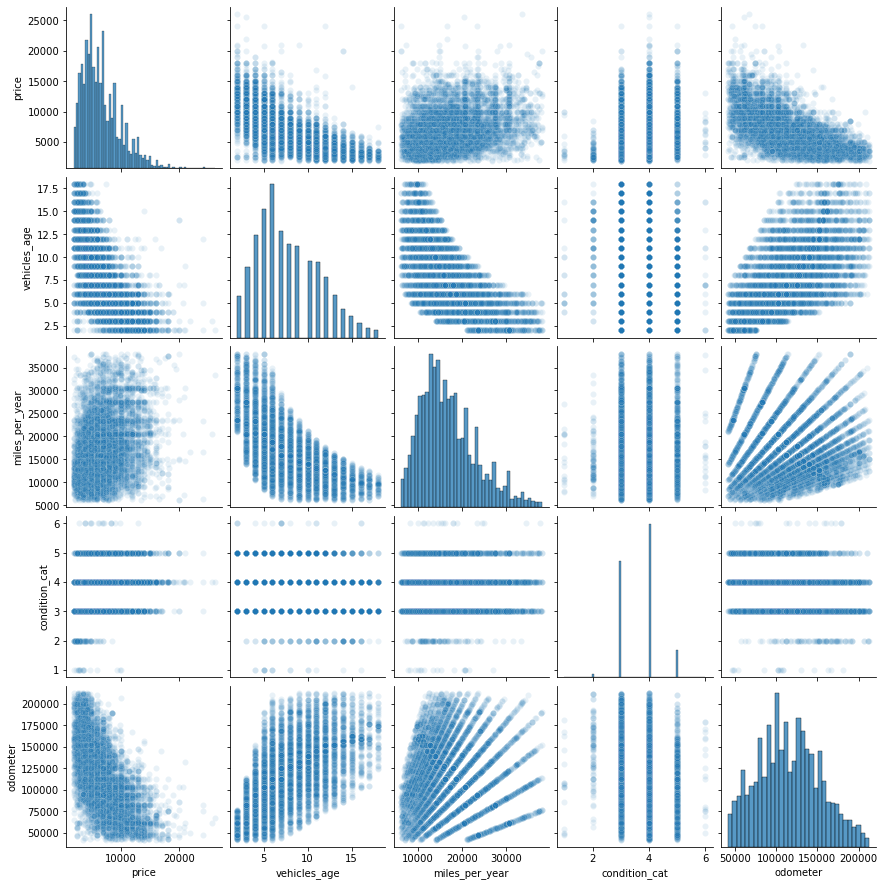

In [74]:
sns.pairplot(for_scatter2, plot_kws={'alpha':0.1})

In [75]:
for_scatter2.corr()

,price,vehicles_age,miles_per_year,condition_cat,odometer
price,1.000000,-0.642053,0.321128,0.230761,-0.621150
vehicles_age,-0.642053,1.000000,-0.686177,-0.177322,0.626825
miles_per_year,0.321128,-0.686177,1.000000,0.052665,0.006342
condition_cat,0.230761,-0.177322,0.052665,1.000000,-0.224987
odometer,-0.621150,0.626825,0.006342,-0.224987,1.000000


### Correlation
* On the sedan type price has the strongest  negetive correlation with age 
* price has also very strong negetive correlation with mileage (odometer)

In [76]:
##Making sure that it has more than 50 listings
sedan['transmission'].value_counts()

automatic    8428
manual        415
other          49
Name: transmission, dtype: int64

In [77]:
sedan_trans = sedan.query("transmission != [ 'other']")

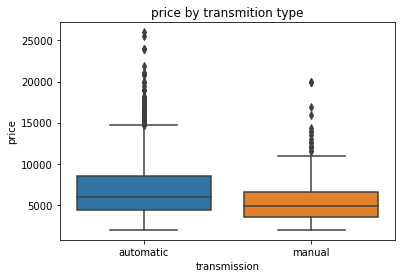

In [78]:

sedan_trans_bar=sns.boxplot(x="transmission", y="price", data=sedan_trans).set_title('price by transmition type')

#### There is no significant differnce in price

In [79]:
##Making sure that it has more than 50 listings
sedan['paint_color'].value_counts()

-         1589
silver    1525
black     1326
grey      1217
white     1071
blue       906
red        682
custom     214
brown      190
green      132
purple      19
yellow      14
orange       7
Name: paint_color, dtype: int64

In [80]:
#getting rid of categories with less than 50 counts
suv_paint = SUV.query("paint_color != ['yellow', 'purple', 'orange']")

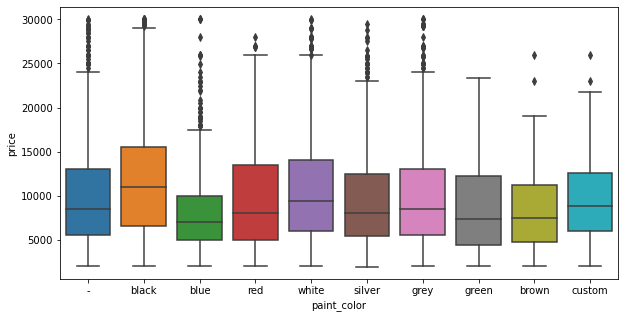

In [81]:
plt.figure(figsize=(10,5))
color_bar=sns.boxplot(x="paint_color", y="price", data=suv_paint)
# if i had a lot of free time i would have matched the colors of the bars to the colors of the cars

####  There is no big difference of price between colors (for sure not a statisticaly significant difference), therefore the paint collor doesnt affect the price much
* The only significant difference is that black is more expensive than blue

## General conclusion

##### Missing data
* All the misiing values were delt with as explained, the only misiing values that I am not sttisfied with is paint_color
##### Outliers
* I got rid of of all the outliers that were highr than 95 percentile or lower than 5 percentile, it shrank the data to be 15% of the original data size, but it made analize possible
##### Correlation
*  In the two most advertised car types we saw strong negetive correlations between price and car age, and price and odometer (mileage).
* meaning - the  older the car is, the lower the price. the more mileage it drove the lower the price is. makes sense.
* another interesting correlation was the negetive correlation between car age and mileage, the older the car is the less it drove per year. maybe it means that people dont drive alot in older cars?